In [2]:
import math
import numpy as np
import pandas as pd
import statsmodels.tsa.stattools as st

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller

#plotting libraries
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt

import seaborn as sns

#Initialize figure size (in inches)
plt.rcParams['figure.figsize'] = [10,5]

pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.10f}'.format

import os
#ALL CREDITS FOR ARFIMA TO https://github.com/hongwai1920/Using-ARIMA-model-to-forecast-returns

# Motivation of Fractional Differencing

* Returns are stationary but memoryless while price series have memory but non-stationary.

* $\textbf{Integer differencing wipe out all memories.}$

* There is a trade-off between stationarity and memory.

Recall that $L$ is the lag operator.
For a real number $d,$ we have 

$$\begin{align*}
(1-L)^d & = \sum_{k=0}^\infty \binom{d}{k} (-L)^k \\
& = 1 - dL + \frac{d(d-1)}{2!} L^2 - \frac{d(d-1)(d-2)}{3!} L^3 + \dots
\end{align*}$$

The arithmetic series consists of 

$$\tilde{X}_t = \sum_{k=0}^\infty \omega_k X_{t-k}$$

with 

$$\omega = \left\{1 ,-d, \frac{d(d-1)}{2!}, -\frac{d(d-1)(d-2)}{3!}, \dots,(-1)^k \prod_{i=0}^{k-1} \frac{(d-i)}{k!},\dots \right\}$$

and 

$$X = {X_t, X_{t-1}, X_{t-2},..., X_{t-k},...}$$

If $d$ is an integer, then 

$$\prod_{i=0}^{k-1} \frac{(d-i)}{k!} = 0 \quad \text{for all } k>d.$$

=========================================================================================================================

# Fractional Differencing Part 1: Finding weights & Formula

* For $k\geq 1,$ if $w_0 = 1,$ the weights can be generated iteratively as:

$$w_k = - w_{k-1} \frac{d-k+1}{k}.$$

* The following findWeights_FFD and fracDiff functions are similar to functions Snippet 5.1 (page $79$) and Snippet 5.2 (page $82$) in Prado's book.

In [3]:
"""Computes the weights for our fractionally differenced features up to a given threshold
   requirement for fixed-window fractional differencing. 
    Args:
        d: A float representing the differencing factor
        length: An int length of series to be differenced
        threshold: A float representing the minimum threshold to include weights for
    Returns:
        A numpy array containing the weights to be applied to our time series
"""
def findWeights_FFD(d, length, threshold):
    #set first weight to be 1 and k to be 1
    w, k = [1.], 1
    w_curr = 1
    
    #while we still have more weights to process, do the following:
    while(k < length):
        
        w_curr = (-w[-1]*(d-k+1))/k
        
        #if the current weight is below threshold, exit loop
        if(abs(w_curr) <= threshold):
            
            break
            
        #append coefficient to list if it passes above threshold condition
        w.append(w_curr)
        
        #increment k
        k += 1
        
    #make sure to convert it into a numpy array and reshape from a single row to a single
    #column so they can be applied to time-series values easier
    w = np.array(w[::-1]).reshape(-1,1)
    
    return w

In [4]:
"""Computes fractionally differenced series 
    Args:
        d: A float representing the differencing factor (any positive fractional)
        series: A pandas dataframe with one or more columns of time-series values to be differenced
        threshold: Threshold value past which we ignore weights 
            (cutoff weight for window)
    Returns: 
        diff_series: A numpy array of differenced series by d. 
"""
def fracDiff(series, d, threshold = 1e-5):
    #compute weights using function above
    weights = findWeights_FFD(d, len(series), threshold)
    width = len(weights) - 1
    
    df = {}
    #for each series to be differenced, apply weights to appropriate prices and save 
    for name in series.columns:
        
        #forward fill through unavailable prices and create a temporary series to hold values
        curr_series = series[[name]].fillna(method='ffill').dropna()
        df_temp = pd.Series()
        
        #loop through all values that fall into range to be fractionally differenced
        for iloc1 in range(width, curr_series.shape[0]):
            
            #set values for first and last time-series point to be used in current pass of fractional
                #difference
            loc0 = curr_series.index[iloc1-width]
            loc1 = curr_series.index[iloc1]
            
            #make sure current value is valid
            if not np.isfinite(curr_series.loc[loc1,name]):
                continue
            
            #dot product of weights with values from first and last indices
            df_temp[loc1]= np.dot(weights.T, curr_series.loc[loc0:loc1])[0,0]
            
        df[name] = df_temp.copy(deep=True)
    df = pd.concat(df, axis=1)
            
    return df

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import math
import time
import datetime
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from collections import deque
from sklearn.utils import shuffle
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_predict

from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV

                    0                1                2                3  \
0      465.8640140000   456.8599850000   394.6730040000   408.0849910000   
1      456.8599850000   424.1029970000   408.0849910000   399.1000060000   
2      424.1029970000   394.6730040000   399.1000060000   402.0920100000   
3      394.6730040000   408.0849910000   402.0920100000   435.7510070000   
4      408.0849910000   399.1000060000   435.7510070000   423.1560060000   
...               ...              ...              ...              ...   
2961 20092.2363300000 20772.8027300000 20595.1035200000 20817.9824200000   
2962 20772.8027300000 20287.9570300000 20817.9824200000 20633.6953100000   
2963 20287.9570300000 20595.1035200000 20633.6953100000 20494.8984400000   
2964 20595.1035200000 20817.9824200000 20494.8984400000 20482.9589800000   
2965 20817.9824200000 20633.6953100000 20482.9589800000 20162.6894500000   

                    4  
0      399.1000060000  
1      402.0920100000  
2      435.7510

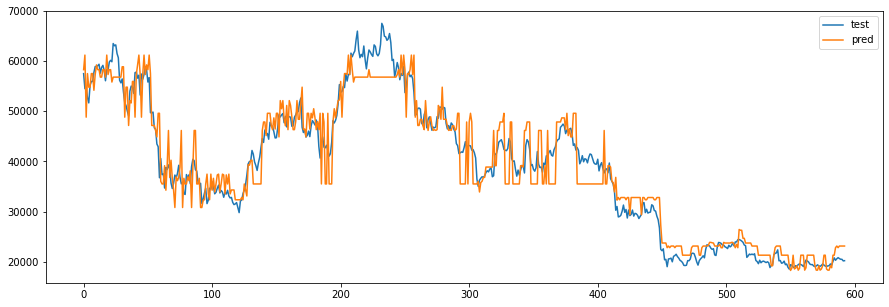

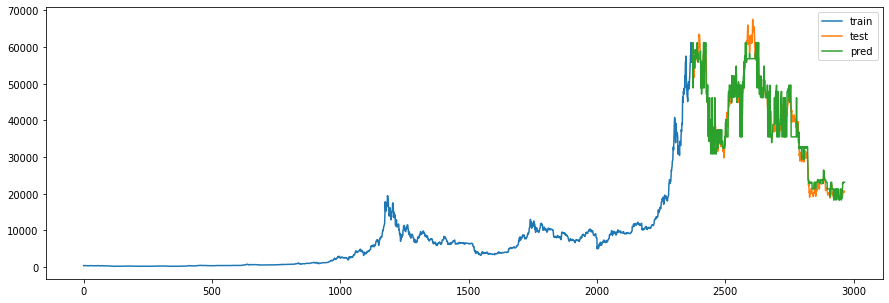

In [12]:
def predict_uno_2(dataset):
    ventana = 3
    predict_size = 1
    df = pd.DataFrame(dataset)
    cols = list()

    '''
    La tabla tiene (t-n) ... (t-1) | (t) ... (t+n)
    '''
    tabla = [list() for i in range(ventana-1+predict_size)]

    for i in range(ventana, len(df)-predict_size): #for i in range(ventana, len(df)-predict_size+1):
        tabla[0].append(df['data'][i-ventana])
        tabla[1].append(df['data'][i-1])
        tabla[2].append(df['data'][i])
    for array in tabla:
        cols.append(pd.Series(array))
    df = pd.concat(cols, axis=1)

    print(df)
    return df
def predict_uno_4(dataset):
    ventana = 5
    predict_size = 1
    df = pd.DataFrame(dataset)
    cols = list()

    '''
    La tabla tiene (t-n) ... (t-1) | (t) ... (t+n)
    '''
    tabla = [list() for i in range(ventana-1+predict_size)]

    for i in range(ventana, len(df)-predict_size):
        tabla[0].append(df['data'][i-ventana])
        tabla[1].append(df['data'][i-ventana+1])
        tabla[2].append(df['data'][i-ventana+3])
        tabla[3].append(df['data'][i-ventana+4])
        tabla[4].append(df['data'][i])
    for array in tabla:
        cols.append(pd.Series(array))
    df = pd.concat(cols, axis=1)

    print(df)
    return df
def predict_uno_consecutivos(dataset, n):
    ventana = n
    predict_size = 1
    df = pd.DataFrame(dataset)
    cols = list()

    '''
    La tabla tiene (t-n) ... (t-1) | (t) ... (t+n)
    '''
    tabla = [list() for i in range(ventana-1+predict_size)]

    for i in range(ventana, len(df)-predict_size+1):
        for j in range(ventana):
            tabla[j].append(df['data'][i-ventana+j])
    for array in tabla:
        cols.append(pd.Series(array))
    df = pd.concat(cols, axis=1)

    print(df)
    return df




dataset = pd.read_csv('https://raw.githubusercontent.com/EduardoZaRo/Mineria-de-datos-571/main/7_Pronostico/btc.csv')
dataset = dataset.rename(columns={"Open": "data"})



'''
dataset = pd.read_csv('https://raw.githubusercontent.com/EduardoZaRo/Mineria-de-datos-571/main/7_Pronostico/MG_dataset.csv')
dataset = dataset.shift(1)
dataset['1.2'][0] = 1.2
dataset = dataset.rename(columns={"1.2": "data"})
'''
df = predict_uno_4(dataset)

labels = df.columns
X = df.loc[:, labels[:-1]].values
y = df.loc[:, labels[-1:]].values

perc = 80
div = round(len(df) * perc/100)
X_train, X_test = X[:div], X[div:]
y_train, y_test = y[:div], y[div:]

model = DecisionTreeRegressor().fit(X_train, y_train)
y_pred = model.predict(X_test)

fig, ax=plt.subplots(figsize=(15, 5))
pd.Series([a[0] for a in y_test]).plot(ax=ax, label='test')
pd.Series(y_pred).plot(ax=ax, label='pred')
ax.legend()

data_train = df[2][:-(len(df)-div)]
data_test  = df[2][-(len(df)-div):]
print(range(div, len(df)), data_test.index)
data_pred = pd.Series(y_pred, index=range(div, len(df)))

fig, ax=plt.subplots(figsize=(15, 5))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
data_pred.plot(ax=ax, label='pred')
ax.legend()

sse = 0
mae = 0
for i in range(len(y_test)):
    mae += abs(y_test[i] - y_pred[i])
    sse += (y_test[i] - y_pred[i])**2
mse = sse/len(y_test)
rmse = np.sqrt(mse)
mae = mae/len(y_test)
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred) 
print("SSE", sse, "\n",
        "MSE", mse, "\n",
        "RMSE", rmse, "\n",
        "MAE", mae, "\n",
        "R2", r2)

                    0                1                2                3  \
0      465.8640140000   456.8599850000   394.6730040000   408.0849910000   
1      456.8599850000   424.1029970000   408.0849910000   399.1000060000   
2      424.1029970000   394.6730040000   399.1000060000   402.0920100000   
3      394.6730040000   408.0849910000   402.0920100000   435.7510070000   
4      408.0849910000   399.1000060000   435.7510070000   423.1560060000   
...               ...              ...              ...              ...   
2960 19344.9648400000 20092.2363300000 20287.9570300000 20595.1035200000   
2961 20092.2363300000 20772.8027300000 20595.1035200000 20817.9824200000   
2962 20772.8027300000 20287.9570300000 20817.9824200000 20633.6953100000   
2963 20287.9570300000 20595.1035200000 20633.6953100000 20494.8984400000   
2964 20595.1035200000 20817.9824200000 20494.8984400000 20482.9589800000   

                    4                5  
0      399.1000060000   402.0920100000  
1    

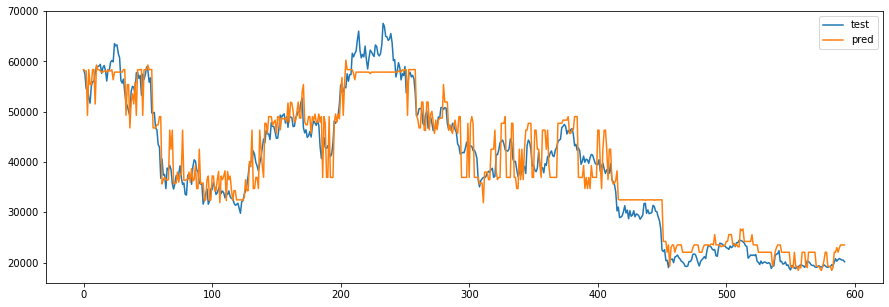

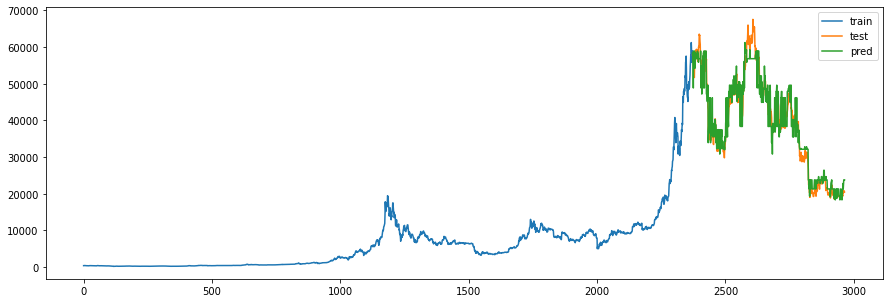

In [13]:
def predict_dos_2(dataset):
    ventana = 3
    predict_size = 2
    df = pd.DataFrame(dataset)
    cols = list()

    '''
    La tabla tiene (t-n) ... (t-1) | (t) ... (t+n)
    '''
    tabla = [list() for i in range(ventana-1+predict_size)]


    for i in range(ventana, len(df)-predict_size):
        tabla[0].append(df['data'][i-ventana])
        tabla[1].append(df['data'][i-1])
        tabla[2].append(df['data'][i])
        tabla[3].append(df['data'][i+1])
    for array in tabla:
        cols.append(pd.Series(array))
    df = pd.concat(cols, axis=1)
    print(df)
    return df
def predict_dos_4(dataset):
    ventana = 5
    predict_size = 2
    df = pd.DataFrame(dataset)
    cols = list()

    '''
    La tabla tiene (t-n) ... (t-1) | (t) ... (t+n)
    '''
    tabla = [list() for i in range(ventana-1+predict_size)]


    for i in range(ventana, len(df)-predict_size):
        tabla[0].append(df['data'][i-ventana])
        tabla[1].append(df['data'][i-ventana+1])
        tabla[2].append(df['data'][i-ventana+3])
        tabla[3].append(df['data'][i-ventana+4])
        tabla[4].append(df['data'][i])
        tabla[5].append(df['data'][i+1])
    for array in tabla:
        cols.append(pd.Series(array))
    df = pd.concat(cols, axis=1)
    print(df)
    return df



dataset = pd.read_csv('https://raw.githubusercontent.com/EduardoZaRo/Mineria-de-datos-571/main/7_Pronostico/btc.csv')
dataset = dataset.rename(columns={"Open": "data"})


'''
dataset = pd.read_csv('https://raw.githubusercontent.com/EduardoZaRo/Mineria-de-datos-571/main/7_Pronostico/MG_dataset.csv')
dataset = dataset.shift(1)
dataset['1.2'][0] = 1.2
dataset = dataset.rename(columns={"1.2": "data"})
'''
df = predict_dos_4(dataset)

labels = df.columns
X = df.loc[:, labels[:-2]].values
y = df.loc[:, labels[-2:]].values

perc = 80
div = round(len(df) * perc/100)
X_train, X_test = X[:div], X[div:]
y_train, y_test = y[:div], y[div:]
print("x_train:",X_train)
model = DecisionTreeRegressor(random_state=0).fit(X_train, y_train)
y_pred = model.predict(X_test)

fig, ax=plt.subplots(figsize=(15, 5))
pd.Series([a[0] for a in y_test]).plot(ax=ax, label='test')
pd.Series([ (a[0]+a[1])/2 for a in y_pred]).plot(ax=ax, label='pred')
ax.legend()

data_train = df[2][:-(len(df)-div)]
data_test  = df[2][-(len(df)-div):]
print(range(div, len(df)), data_test.index)
data_pred = pd.Series([a[0] for a in y_pred], index=range(div, len(df)))

fig, ax=plt.subplots(figsize=(15, 5))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
data_pred.plot(ax=ax, label='pred')
ax.legend()

sse = 0
mae = 0
for i in range(len(y_test)):
    for j in range(len(y_test[i])):
        mae += abs(y_test[i][j] - y_pred[i][j] )
        sse += (y_test[i][j] - y_pred[i][j] )**2
mse = sse/len(y_test)
rmse = np.sqrt(mse)
mae = mae/len(y_test)
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred) 
print("SSE", sse, "\n",
        "MSE", mse, "\n",
        "RMSE", rmse, "\n",
        "MAE", mae, "\n",
        "R2", r2)

                    0                1                2                3  \
0      465.8640140000   456.8599850000   424.1029970000   394.6730040000   
1      456.8599850000   424.1029970000   394.6730040000   408.0849910000   
2      424.1029970000   394.6730040000   408.0849910000   399.1000060000   
3      394.6730040000   408.0849910000   399.1000060000   402.0920100000   
4      408.0849910000   399.1000060000   402.0920100000   435.7510070000   
...               ...              ...              ...              ...   
2962 20772.8027300000 20287.9570300000 20595.1035200000 20817.9824200000   
2963 20287.9570300000 20595.1035200000 20817.9824200000 20633.6953100000   
2964 20595.1035200000 20817.9824200000 20633.6953100000 20494.8984400000   
2965 20817.9824200000 20633.6953100000 20494.8984400000 20482.9589800000   
2966 20633.6953100000 20494.8984400000 20482.9589800000 20162.6894500000   

                    4  
0      408.0849910000  
1      399.1000060000  
2      402.0920

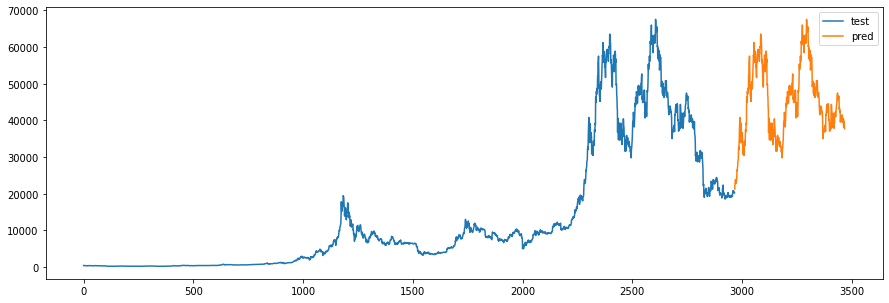

In [14]:

dataset = pd.read_csv('https://raw.githubusercontent.com/EduardoZaRo/Mineria-de-datos-571/main/7_Pronostico/btc.csv')
dataset = dataset.rename(columns={"Open": "data"})
dataset = dataset.dropna()

'''
dataset = pd.read_csv('https://raw.githubusercontent.com/EduardoZaRo/Mineria-de-datos-571/main/7_Pronostico/MG_dataset.csv')
dataset = dataset.shift(1)
dataset['1.2'][0] = 1.2
dataset = dataset.rename(columns={"1.2": "data"})
'''
ventana = 5

df = predict_uno_consecutivos(dataset, ventana)

labels = df.columns
X = df.loc[:, labels[:-1]].values
y = df.loc[:, labels[-1:]].values

perc = 95
div = round(len(df) * perc/100)
X_train, X_test = X[:div], X[div:]
y_train, y_test = y[:div], y[div:]

model = DecisionTreeRegressor().fit(X_train, y_train)


values = df.values
x_test = values[len(df)-1:, :]
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1]))[:,:-1]
results=[]
for i in range(ventana-1):
    x_test[0][i] = df.values[-1][i+1]

future_steps = 500
for i in range(future_steps+1):
    parcial=model.predict(x_test)
    for i in range(ventana-1):
        x_test[0][i] = df.values[-1][i+1]
    x_test[0][ventana-2] = parcial[0]
    results.append(parcial[0])

fig, ax=plt.subplots(figsize=(15, 5))
pd.Series([a[0] for a in y]).plot(ax=ax, label='test')
pd.Series(results, index = range(len(y), len(y)+future_steps+1)).plot(ax=ax, label='pred')
ax.legend()


2972
test_series                        data
2000-01-01   465.8640140000
2000-01-02   456.8599850000
2000-01-03   424.1029970000
2000-01-04   394.6730040000
2000-01-05   408.0849910000
...                     ...
2008-02-15 20494.8984400000
2008-02-16 20482.9589800000
2008-02-17 20162.6894500000
2008-02-18 20208.7695300000
2008-02-19 21295.3808600000

[2972 rows x 1 columns]


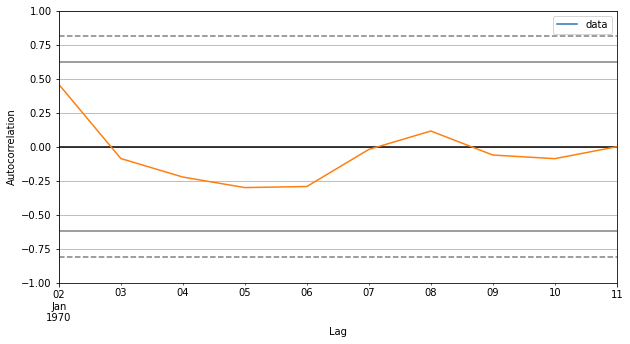

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


                       data
2004-08-30  7030.7814862464
2004-08-31  6480.2537009963
2004-09-01  6411.3049389236
2004-09-02  7341.3226200029
2004-09-03  7102.7661578455
...                     ...
2008-02-15 17032.3496228440
2008-02-16 17022.1336154830
2008-02-17 16702.7033058382
2008-02-18 16755.7484289968
2008-02-19 17845.1198282466

[1269 rows x 1 columns]


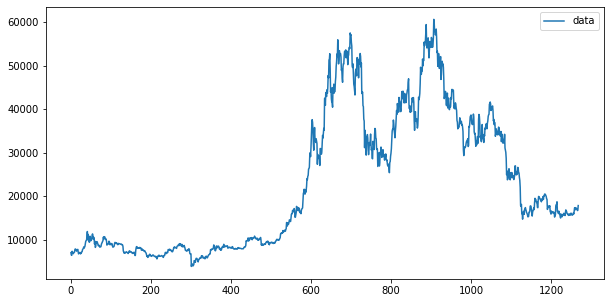

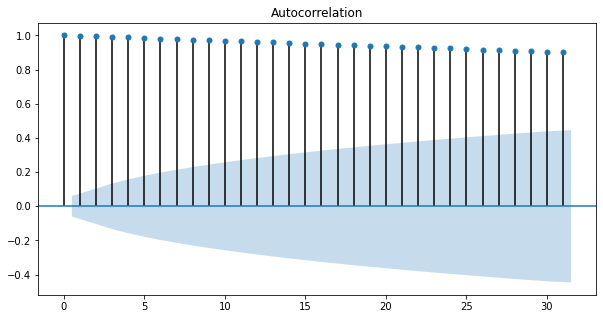

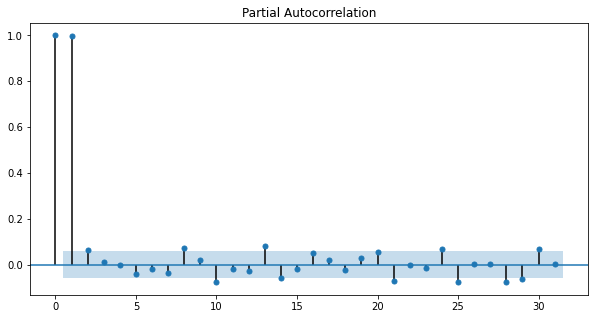

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                 1069
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -9131.344
Date:                Mon, 28 Nov 2022   AIC                          18270.689
Time:                        04:27:21   BIC                          18290.587
Sample:                             0   HQIC                         18278.227
                               - 1069                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.305e+04   1.38e+04      1.669      0.095   -4020.710    5.01e+04
ar.L1          0.9416      0.023     40.105      0.000       0.896       0.988
ar.L2          0.0556      0.023      2.390      0.0

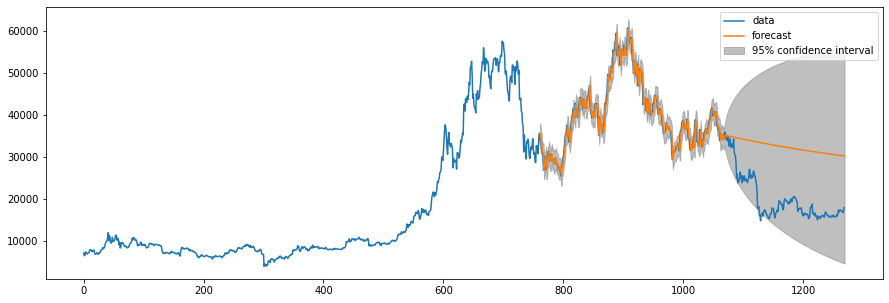

"\nX = df.values\nsize = int(len(X) * 0.95)\ntrain, test = X[0:size], X[size:len(X)]\nhistory = [x for x in train]\npredictions = list()\n# walk-forward validation\nfor t in range(len(test)):\n\tmodel = ARIMA(history, order=(5,0,0))\n\tmodel_fit = model.fit()\n\toutput = model_fit.forecast()\n\tyhat = output[0]\n\tpredictions.append(yhat)\n\tobs = test[t]\n\thistory.append(obs)\n\tprint('predicted=%f, expected=%f' % (yhat, obs))\n\n# plot forecasts against actual outcomes\nplt.plot(test)\nplt.plot(predictions, color='red')\nplt.show()\n"

In [25]:
from datetime import date, timedelta
'''
dataset = pd.read_csv('https://raw.githubusercontent.com/EduardoZaRo/Mineria-de-datos-571/main/7_Pronostico/MG_dataset.csv')
sdate = date(2000,1,1)   # start date
edate = date(2003,4,15)   # end date
print(dataset.T.values.tolist()[0])
df = pd.DataFrame({"data":dataset.T.values.tolist()[0]}, pd.date_range(sdate,edate-timedelta(days=1),freq='d'))
df.index = pd.to_datetime(df.index)
print(df)
test_series = df
'''

dataset = pd.read_csv('https://raw.githubusercontent.com/EduardoZaRo/Mineria-de-datos-571/main/7_Pronostico/btc.csv')
sdate = date(2000,1,1)   # start date
edate = date(2008,2,20)   # end date
print(len(dataset))
df = pd.DataFrame({"data":dataset.T.values.tolist()[0]}, pd.date_range(sdate,edate-timedelta(days=1),freq='d'))
df.index = pd.to_datetime(df.index)

test_series = df
test_series.plot()
print("test_series", test_series)

from pandas.plotting import autocorrelation_plot

autocorrelation_plot(dataset[:10])
plt.show()

df_result = fracDiff(test_series, 0.02, 1e-5) #Fractional diff
print(df_result)

df_result =df_result.reset_index()
df_result[['data']].plot()

df = pd.DataFrame({"data":df_result[['data']].T.values.tolist()[0]})




msk = (df.index < len(df_result)-200)
df_train = df[msk].copy()
df_test = df[~msk].copy()




from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
acf_original = plot_acf(df_train)
plt.show()
pacf_original = plot_pacf(df_train)
plt.show()






from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_train, order=(2,0,0))
model_fit = model.fit()
print(model_fit.summary())

from statsmodels.graphics.tsaplots import plot_predict
fig, ax = plt.subplots(figsize=(15, 5))
s = pd.DataFrame(list(range(len(df))))
ax = df.loc[:].plot(ax=ax)
perc = 40
plot_predict(model_fit, len(df)-round(len(df) * perc/100), len(df), ax=ax)
plt.show()
'''
X = df.values
size = int(len(X) * 0.95)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,0,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))

# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()
'''